<a href="https://colab.research.google.com/github/yixin0829/multi_label_wine_quality_classification/blob/master/Wine_Quality_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Label Wine Quality Classification


---







In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Context & Workflow in Mind
The dataset is pulled through Kaggle API. The dataset is related to red variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference [Cortez et al., 2009].

### **Tools & Models**


**The plan** is to use the dataset to train some multi-label classification models using different ML models and compare their performance + analyze why they differentiate: 


*   Logistic regression
*   K-NN
*   SVM



### **Workflow**



*   Import libraries & data
*   Exploratory analysis & Data visualization
*   Data preprocessing
*   Rapid prototyping (train a logistic regression classifer with one vs. all method)
*   Feature engineering
*   Interating for better performance (precision/recall & F score)

## Import Libararies

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Use the right version of TensorFlow
The following hidden code cell ensures that the Colab will run on TensorFlow 2X.

In [3]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x

## Downloading dataset (Kaggle API)

Not sure comparing with downloading dataset from Kaggle which method is better. My understanding is using API might just demostrate a bit more knowledge of API and also can indicate the data source. The down side could be I'm exposing my user name and token?

In [ ]:
#@title Setting up Kaggle API
#!pip install kaggle
!rm -r .kaggle
!mkdir .kaggle

import json
token = {"username":"MY USER NAME","key":"<KEY>"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

rm: cannot remove '.kaggle': No such file or directory
cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# Downloading dataset from Kaggle
#@title Viewing datasets from Kaggle
!kaggle datasets list -s Red

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
# Copy the API key from Kaggle and set the path -p
!kaggle datasets download -d uciml/red-wine-quality-cortez-et-al-2009 -p /content/

# Unzip the datasets just downloaded
!unzip \*.zip
# Remove the extra .zip file
!rm /content/*.zip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.
rm: cannot remove '/content/*.zip': No such file or directory


## Importing Dataset

In [4]:
wine_df = pd.read_csv("./drive/My Drive/Multi-label Wine Quality Classification/winequality-red.csv")
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
wine_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [6]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


## Exploratory Analysis & Data Visualizations

### Skewed Classes

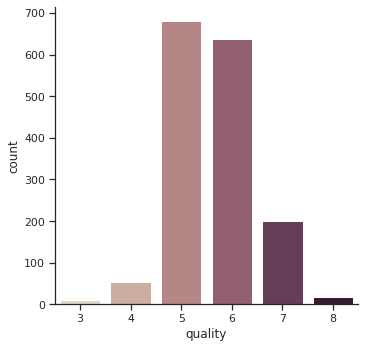

In [7]:
# Visualize the categorical labels first
sns.set(style="ticks", color_codes=True)

sns.catplot(x="quality", kind="count", palette="ch:.25", data=wine_df);

Note that the classes are pretty unenvenly distributed. There are much more normal wines than excellent or poor ones (Need to research more on how to deal with situation). In general seems we got 6 categaories in here from grading 3 - 8.

### Correlation Analysis

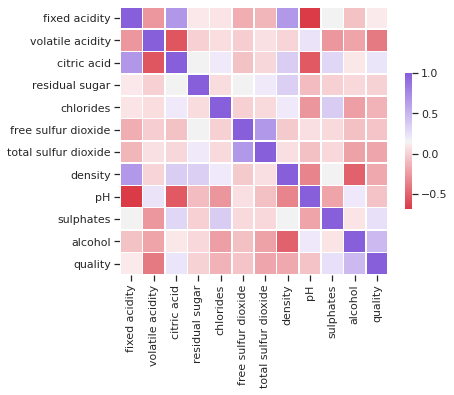

In [8]:
corr = wine_df.corr(method = 'pearson')
f, ax = plt.subplots(figsize=(6, 5))
cmap = sns.diverging_palette(10, 275, as_cmap=True)

sns.heatmap(corr, cmap=cmap, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.5}, ax=ax)

Seems PH and fixed acidity, citric acid and PH/volatile acidity have high negtive correlation. Later we can consider to combine these features by apply principal component analysis (PCA). However, for now let's get something quick and dirty working first. However it may be helpful to plot the xy scattet plots for better visualization of the correlations between different features.

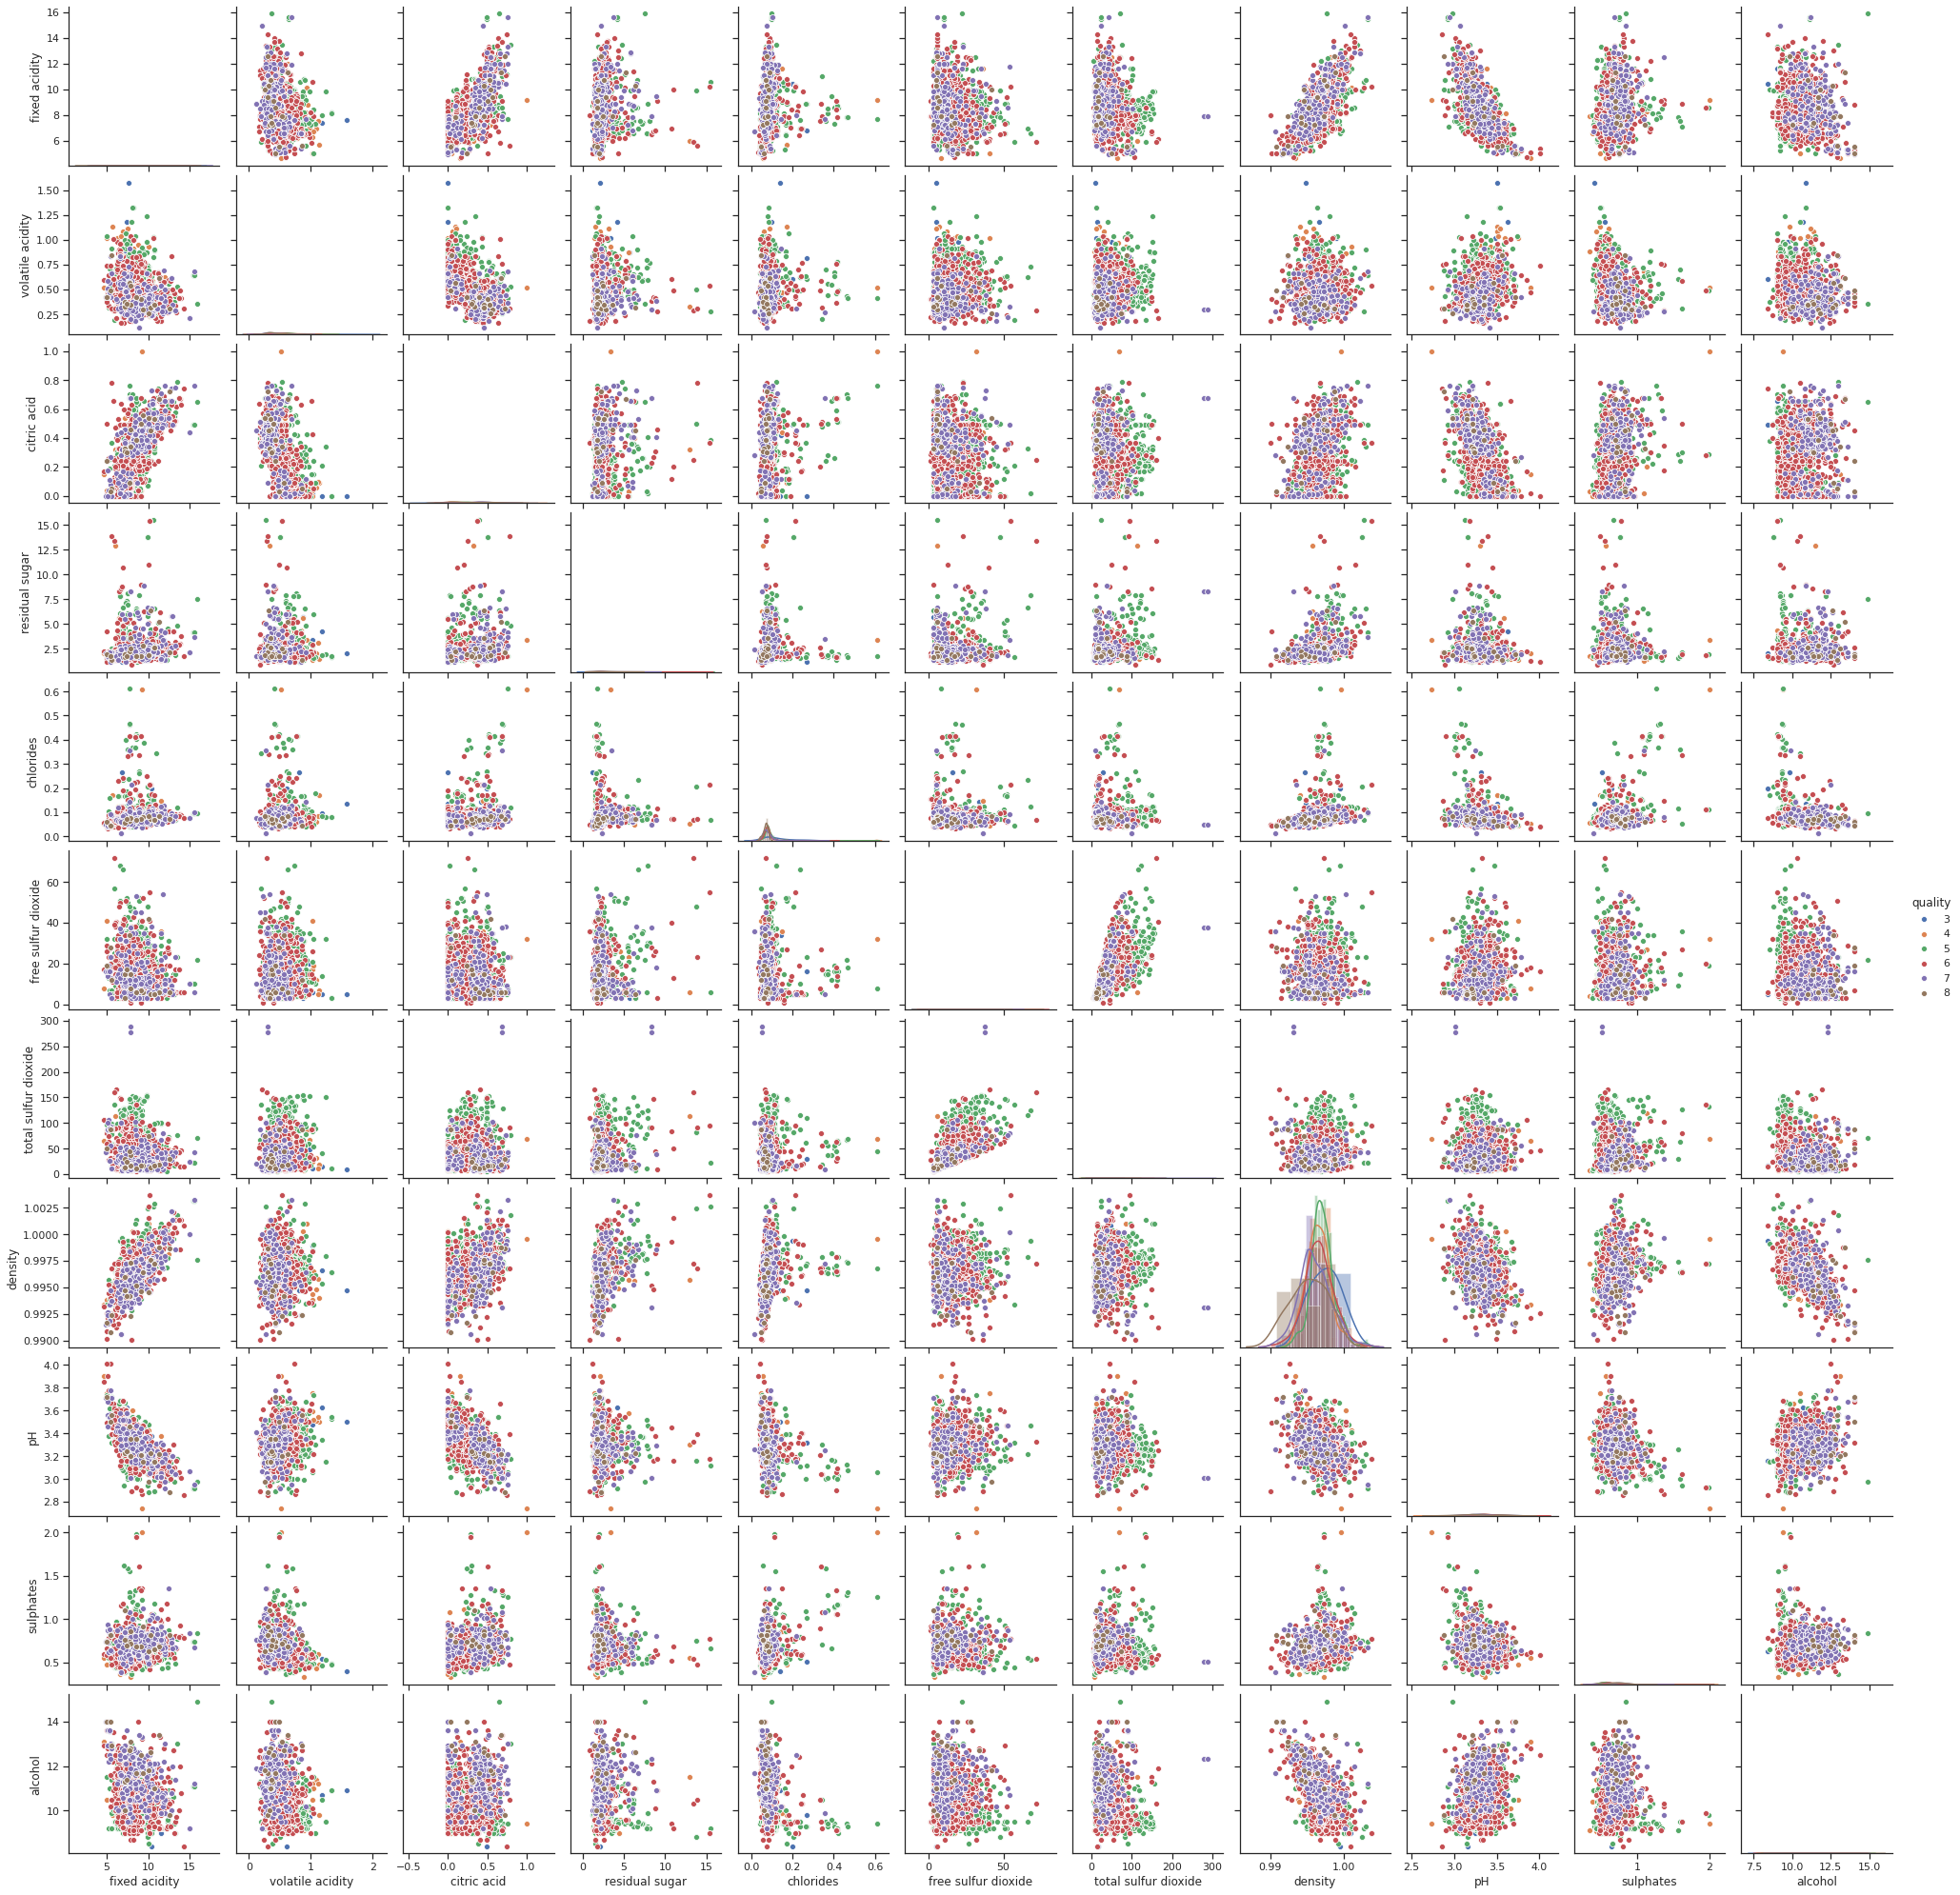

In [9]:
g = sns.PairGrid(wine_df, hue="quality")
g.map_diag(sns.distplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

### Plotting Features w.r.t. Labels (Wine Quality)

A bar plot represents an estimate of central tendency for a numeric variable with the height of each rectangle and provides some indication of the uncertainty around that estimate using error bars.

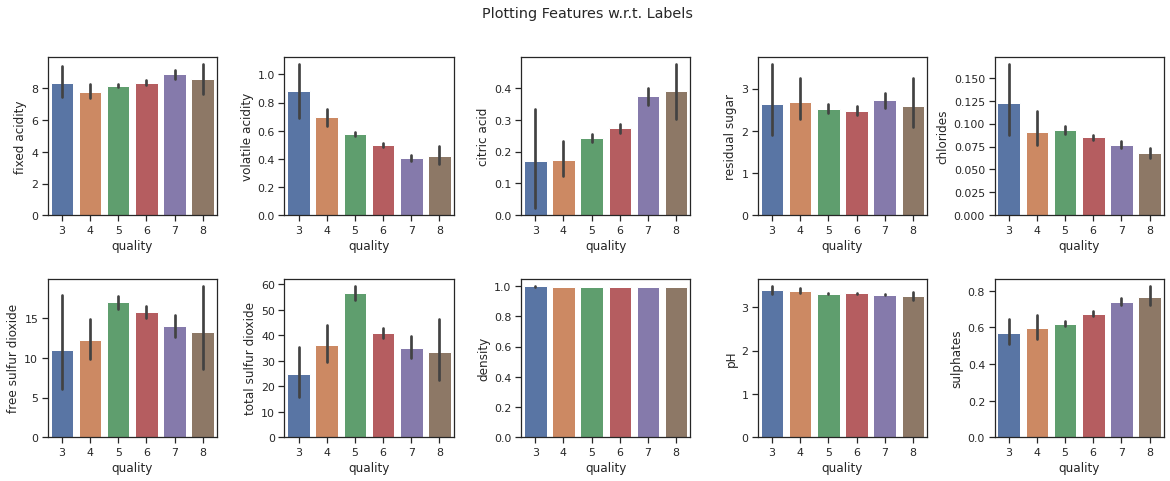

In [10]:
# Creating a 2 x 5 subplot grid
figure, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,7))
figure.suptitle("Plotting Features w.r.t. Labels")
# wspace: the amount of width reserved for space between subplots, expressed as a fraction of the average axis width
# hspace; the amount of height reserved for space between subplots, expressed as a fraction of the average axis height
figure.subplots_adjust(hspace=0.4, wspace= 0.4)

# Using for loop to interate through different features and plot its barplot against wine "quality" feature (categorical data)
for i in range(2):
  for j in range(5):
    sns.barplot(ax=axes[i,j], x='quality', y=wine_df.columns[i*5 + j], data = wine_df)


From the barplots above we see features like "fixed acidity", "residual sugar", "density", "PH" have almost no effect on predicting the quality of wine. We'll take out feature "density" in here since it does not have any error bar meaning consistent data quality.

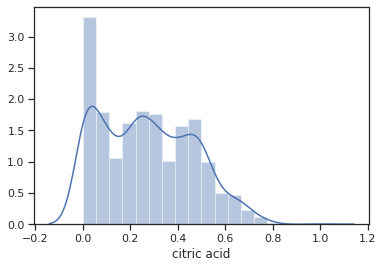

In [11]:
# Visualize the distribution of citric acid since previously apply .describe() on wine_df citric acid has a minimum of 0
citric_acid = pd.Series(wine_df.loc[:,'citric acid'])
sns.distplot(citric_acid)

Not sure if citric acid = 0 is valid or not.

## Data Preprocessing (Feature Scaling)

### Drop "density" data column

We'll drop "density" column as we discussed in the exploratory analysis section and keep the rest data the same. For more in depth preprocessing (e.g. PCA), we'll come back to it later after we trained our first quick, dirty classifier using logistic regression.

In [12]:
wine_df = wine_df.drop(labels='density', axis=1)
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,3.51,0.56,9.4,5


### Encoding the 'quality' col


In [13]:
wine_df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [14]:
# instead of using sklearn.preprocessing -> OneHotEncoder class (which require to convert pandas dataframe to numpy array)
# We use pandas' get_dummies method, notice the prefix param makes the resulted one hot key encoded matrix more readable
one_hot_label = pd.get_dummies(wine_df.quality, prefix='quality')
one_hot_label.head()

,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


In [26]:
# .values Return a Numpy representation of the DataFrame
X = wine_df.iloc[:, :-1].to_numpy()
y_one_hot = one_hot_label.to_numpy()
y = wine_df.iloc[:, -1].to_numpy()
print("the dimension of X training examples is:" + str(X.shape) + "\n the dimension of y training examples is:" + str(y.shape))

the dimension of X training examples is:(1599, 10)
 the dimension of y training examples is:(1599,)


### Splitting into Training/Test Sets

Different from binary classification problem, in here we'll have 6 y_train & y_test label sets each corresponding one column in the y matrix. The first step is to split the numpy arrays into trianing & test sets.

In [27]:
from sklearn.model_selection import train_test_split
# Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes
# Note we've converted our preprocessed pandas dataframes into numpy arrays with to_numpy() method in the last code cell
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
print(X_train.shape)

(1279, 10)


In [28]:
print(y_train.shape)

(1279,)


### Feature Scaling

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit_tranform call .fit() to compute the mean and std deviation for later use 
X_train = scaler.fit_transform(X_train)
# No need to call fit_transform again since the params have been computed in the previous line
X_test = scaler.transform(X_test)

In [19]:
print(X_train)

[[-0.73307913  0.6648928  -1.25704443 ...  0.98846046  0.0630946
  -0.87223395]
 [ 1.06774091 -0.62346154  1.52314768 ... -1.7535127  -0.17390392
  -0.77978452]
 [-1.74604041 -1.07158479 -1.35814232 ...  2.32756363  0.77409018
   3.28799021]
 ...
 [-0.95818164  1.08500835 -0.90320179 ...  0.22325865 -1.00339876
   0.32960859]
 [-0.62052788  0.55286199 -1.35814232 ...  0.35079228 -0.47015208
  -1.33448108]
 [ 0.44870902 -0.73549236  1.16930505 ... -0.6694768   0.18159387
   1.90124882]]


## Train a multi-class logistic regression classifier (one vs. all)

In [31]:
from sklearn.linear_model import LogisticRegression

# No params are passing in here into the LogisticRegression class (i.e. no tuning)
logReg_clf = LogisticRegression(random_state = 0, multi_class='ovr').fit(X_train, y_train)

## Predicting the Test Set Results

In [34]:
# Predit the test data Note: the output y_pred is a numpy array
y_pred = logReg_clf.predict(X_test)

from sklearn.metrics import classification_report
#Let's see how our model performed
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       1.00      0.08      0.14        13
           5       0.63      0.76      0.69       140
           6       0.56      0.58      0.57       134
           7       0.25      0.07      0.11        30
           8       0.00      0.00      0.00         2

    accuracy                           0.59       320
   macro avg       0.41      0.25      0.25       320
weighted avg       0.57      0.59      0.56       320



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.

The support is the number of samples of the true response that lie in that class.

### Making the confusion Matrix

In [37]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[  0   0   1   0   0   0]
 [  0   1   8   4   0   0]
 [  0   0 107  32   1   0]
 [  0   0  52  78   4   0]
 [  0   0   3  25   2   0]
 [  0   0   0   1   1   0]]
